In [128]:
%matplotlib notebook
import math
from collections import Counter
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyximport
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.interpolate import interp1d
from scipy.spatial.distance import pdist, squareform
from sklearn import manifold
from sklearn.preprocessing import minmax_scale

pyximport.install()
from frechet import frechet
plt.rcParams['figure.figsize'] = [10, 8]

In [34]:
indicator_name2 = ['International migrant stock, total',
                   'Merchandise exports (current US$)',
                   'Merchandise imports (current US$)',
                   'GDP (current US$)',
                   'GDP per capita (current US$)',
                   'GNI (current US$)',
                   'Exports of goods and services (% of GDP)',
                   'External balance on goods and services (% of GDP)',
                   'Imports of goods and services (% of GDP)',
                   'Trade (% of GDP)',
                   'Exports of goods and services (current US$)',
                   'Imports of goods and services (current US$)',
                   'Military expenditure (% of GDP)',
                   'Gross national expenditure (current US$)',
                   'Inflation, consumer prices (annual %)'
                   ]

In [35]:
df = pd.read_csv('WDI_csv/WDIData.csv',index_col='Country Name')
df = df.iloc[:, :-1]
print(df.shape)

(422400, 61)


In [36]:
def get_most_common_n(n):
    a = df[df['1960'].notnull()]['Indicator Name']
    test = Counter()
    for b, c in zip(a, a.index):
        test[b] += 1
    return test.most_common(n)

In [147]:
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
from scipy.optimize import curve_fit
import math
import copy

def func_linear(x, a, b):
    return a + b * x

def func_cubic(x, a, b, c, d):
    return a + b * x + c * x**2 + d * x**3


def get_interpoled_data(datas):
    datas_copy = copy.deepcopy(datas)
    for i in range(datas.shape[0]):
    # for i in range(0, 1):
        original_row = datas.iloc[i:i+1,:]
        curated_row = original_row.dropna(axis='columns', how='any')
        
        if len(curated_row.values[0]) == 0:
            continue
            
        original_row = original_row.iloc[0]
        curated_row = curated_row.iloc[0]
        
        indexes = original_row.index.values
        indexes = indexes.astype(np.float)
    
        x = curated_row.index.values
        x = x.astype(np.float)
        y = curated_row.values
        
        f = interp1d(x, y, kind='linear', fill_value='extrapolate')
        cubicspline = CubicSpline(x, y, extrapolate='None')
        Pchip = PchipInterpolator(x, y, extrapolate='True')
        
        z = np.polyfit(x, y, 4)
        p = np.poly1d(z)
        
#         popt_linear, _ = curve_fit(func_linear, x, y)
#         popt_cubic, _ = curve_fit(func_cubic, x, y)
        
        flag = False
        for n in range(len(indexes)):
            if math.isnan(datas_copy.iat[i,n]):
                value = Pchip(indexes[n])
                if(value < 0):
#                     print(value)
                    value = 0
                datas_copy.iat[i,n] = value
                flag = True
        if flag:
#             print(datas_copy.iloc[i:i+1,:].values)
            pass
    return datas_copy


def distance_matrix(X, f='correlation'):
    return pdist(X, metric=f)


def get_data_by_name(name, name_list):
    data = df[df['Indicator Name'] == name]
    data = data.iloc[:, 3:]
    data = get_interpoled_data(data)
    return data, data.index


def pretty_plot(ds, datas, tmp, name):
    t0 = time()
    mds = manifold.TSNE(2, random_state=0, metric='precomputed')
    Y = mds.fit_transform(ds)
    t1 = time()
    color = [tmp[i] for i in range(len(Y))]
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("TSNE (%.2g sec) %s" % ((t1 - t0), name))
    for i, txt in enumerate(datas):
        plt.annotate(txt, (Y[i, 0], Y[i, 1]), size=6)
    plt.savefig(name + ".png", dpi = 500, bbox_inches='tight')
    plt.savefig(name + ".pdf", dpi = 500, bbox_inches='tight')
    plt.show()

In [66]:
# xnew = np.linspace(1960, 2017, endpoint=True)
# plt.plot(x, y, 'o', xnew, p(xnew), '-', xnew, cubicspline(xnew), '--', xnew, Pchip(xnew), '-', 
#          xnew, func_linear(xnew, *popt_linear), 'r-', xnew, func_cubic(xnew, *popt_cubic), 'b-')
# plt.legend(['data', 'polyfit interpolation', 'cubicspline interpolation', 'Pchip interpolation',
#             'linear function approximate', 'cubic function approximate'], loc='best')
# plt.show()

In [67]:
in_list = []
name_list = set(df.index)
for name in indicator_name2:
    try:
        frame, names = get_data_by_name(name, name_list)
        in_list.append(frame)
        name_list &= set(names)
    except ValueError:
        print(name)
        continue

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RankWarning: Polyfit may be poorly conditioned


Gross national expenditure (current US$)


In [68]:
len(name_list)

264

In [99]:
import scipy
def calculate(scales, out_list, method):
    print(scipy.special.binom(out_list[0].shape[0], 2))
    result = np.zeros(shape=(int(scipy.special.binom((out_list[0].shape[0]), 2),)))
    for scale, X in zip(scales, out_list):
        result += scale * distance_matrix(X, f=method)
    return result


In [100]:
out_list = []
name_list = sorted(list(name_list))

for pool in in_list:
#     test_pool df.fillna(0, inplace=True)
    out_list.append(minmax_scale(pool.loc[name_list].fillna(0, inplace=False).values, axis=0))
# print(out_list)
np.random.seed(3345)
scales = np.random.rand(len(out_list))

In [101]:
result_dtw = calculate(scales, out_list, dtw.distance_fast)
result_frechet = calculate(scales, out_list, frechet)
result_corr = calculate(scales, out_list, 'correlation')


34716.0
34716.0
34716.0


<IPython.core.display.Javascript object>


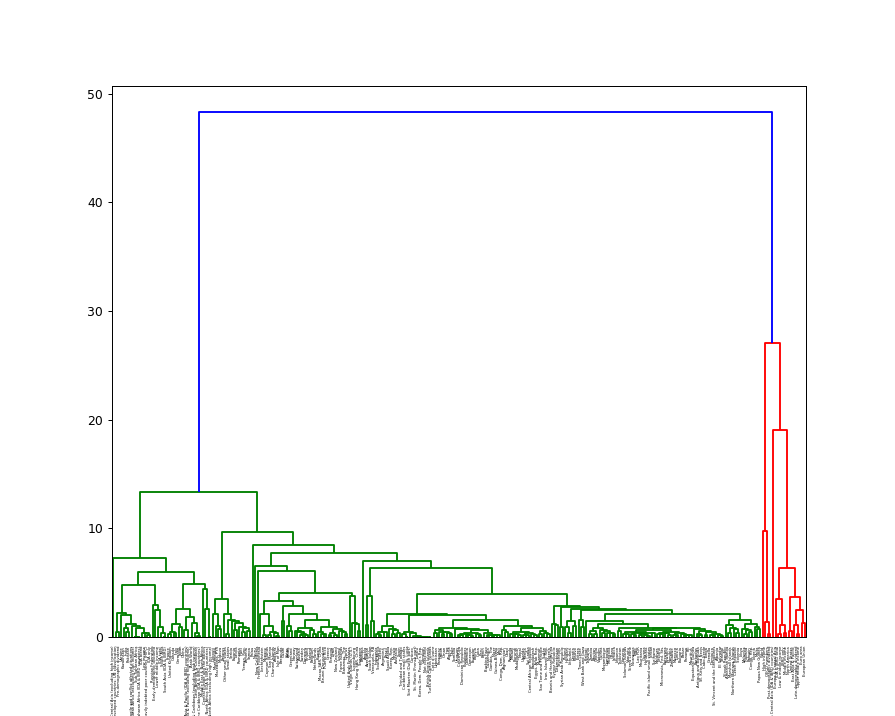

In [137]:
dist = ward(result_dtw)
dendrogram(dist, labels=name_list, leaf_font_size=3)
plt.savefig("result_dtw.png", dpi = 500, bbox_inches='tight')
plt.savefig("result_dtw.pdf", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


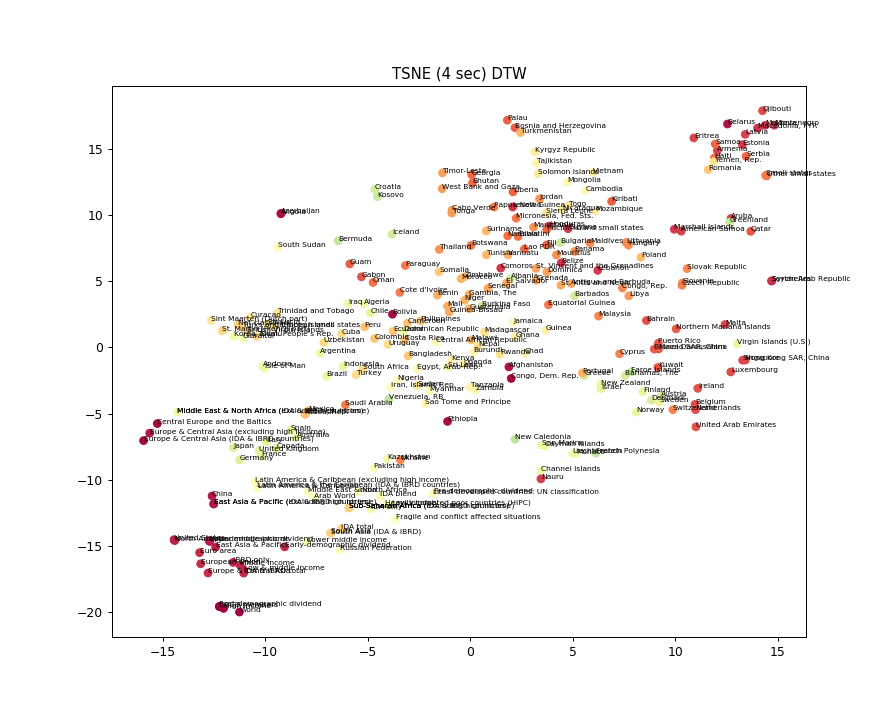

In [153]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_dtw), name_list, [colors[i] for i in tmp], 'DTW')

<IPython.core.display.Javascript object>


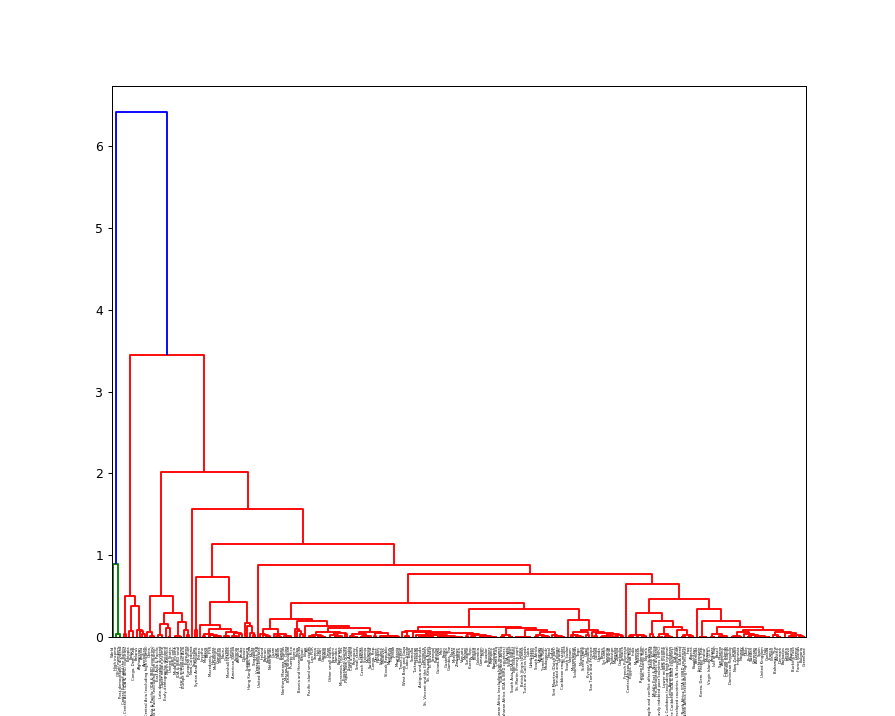

In [152]:
dist = ward(result_frechet)
dendrogram(dist, labels=name_list, leaf_font_size=3)
plt.savefig("result_frechet.png", dpi = 500, bbox_inches='tight')
plt.savefig("result_frechet.pdf", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


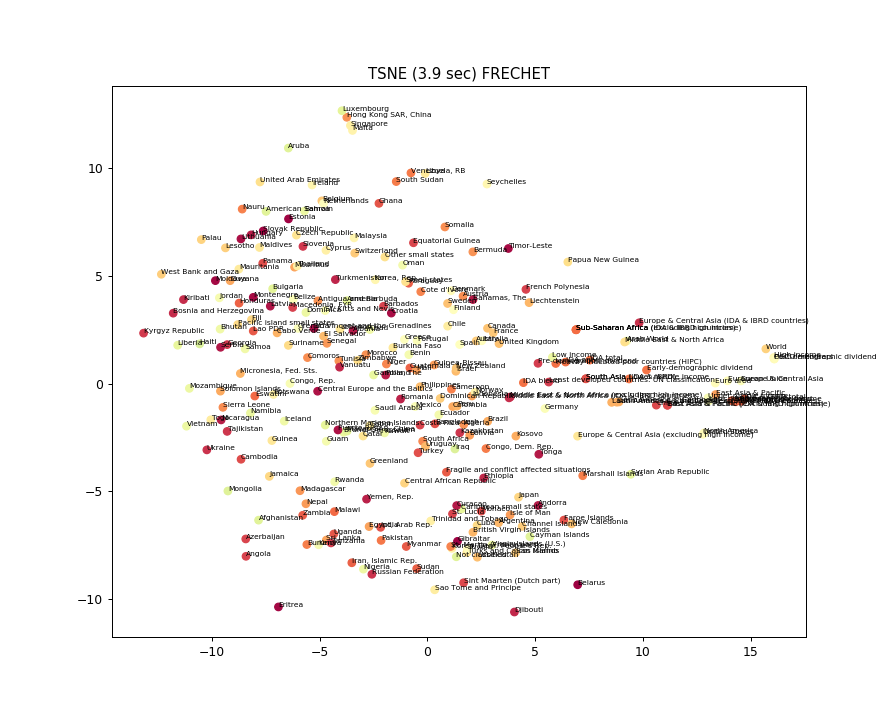

In [151]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_frechet), name_list, [colors[i] for i in tmp], 'FRECHET')

<IPython.core.display.Javascript object>


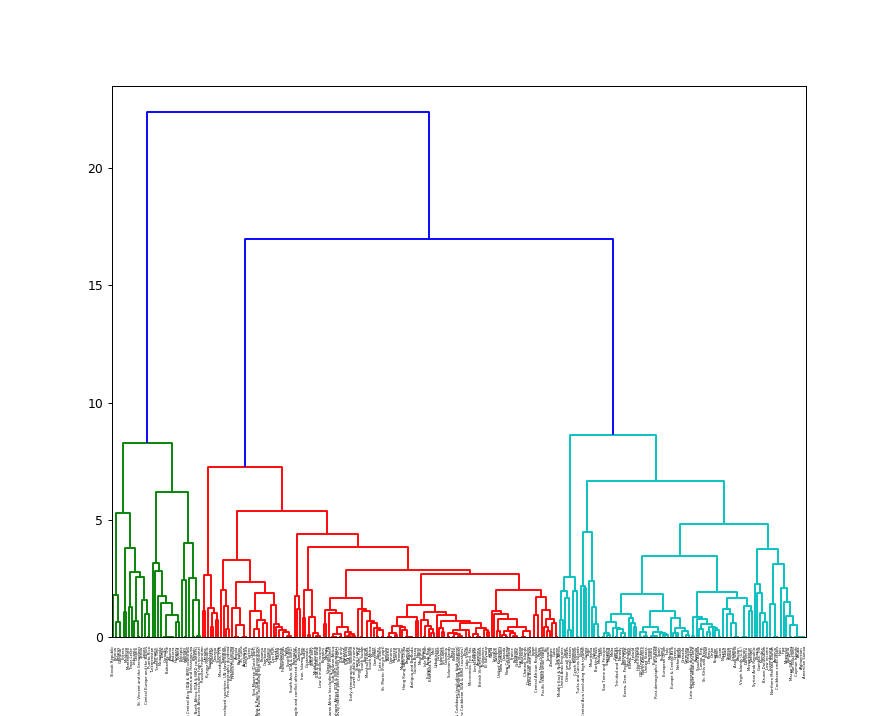

In [150]:
result_corr[np.isinf(result_corr)] = 0
np.nan_to_num(result_corr, False)
dist = ward(result_corr)
dendrogram(dist, labels=name_list, leaf_font_size=3)
plt.savefig("result_corr.png", dpi = 500, bbox_inches='tight')
plt.savefig("result_corr.pdf", dpi = 500, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


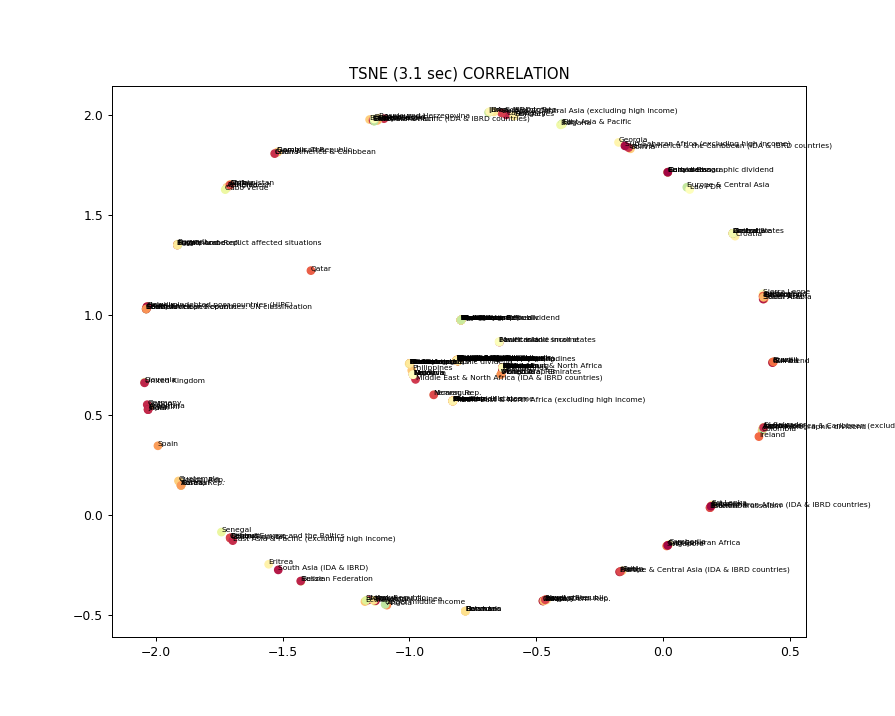

In [149]:
tmp = fcluster(dist, t=0.4)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(tmp))]
pretty_plot(squareform(result_corr), name_list, [colors[i] for i in tmp], 'CORRELATION')